<h1 align="center"> Movie Recommender System Implementation and Comparison</h1>  

**Note:** *The course project of SDSC3002-Data Mining*   
Group Member:   
*SID: 56641800&emsp; &emsp; Name: Du Junye*  
*SID: 55670256&emsp; &emsp; Name: Shan Jinyun*    
*SID: 56236609&emsp; &emsp; Name: Li Zhangchao*    
*SID: 56197665&emsp; &emsp; Name: Zhang Zirui*  
*This project is only for the use of course requirement of sdsc3002*  

<b>Before we Begin:  </b>   
In order to run the code, necessary pckages are required, make sure the following packages have already been installed in your computer: 

+ Basic scientific calculation libraries: Numpy, Pandas, Matplotlib  
+ Advanced Visualization libraies: Seaborn 
+ Packages for dynamic graphs: Cufflinks, Plotly
+ Packages for machine learning and deep learning: Sklearn, Pytorch(GPU version), Keras   
+ Recommender Algorithms support: Surprise
+ Natural Language Processing: nltk
+ Python type modification: ast 

 


<b> Introduction to Our Goals: </b>  
*In our project, we want to implement different recommender algorithms and compare their performance, the outline of the project is as followed.*


<b> Outline: </b>  

I. <b>Data pre-processing</b><br>  
> Missing value handling   
> Movie information extraction   
> Feature engineering   
> Addition data modification 

II. <b>Data exploration and visualization</b><br>   
> Introduce weighted rating   
> Trend of quantities of different types of films 

III. <b>Collabrative Filtering Algorithms</b><br> 
> Baseline, SVD, KNN with means methods   
> Performance comparison 


IV. <b> Movie Recommender Implementation</b><br> 
> User-rating based recommender   
> Description based recommender   
> Keyword based recommender   
> Hybrid recommender   
> Deep Learning method 


<b> References: </b>
<ul> 
<li>Hands on Machine Learning with Scikit-Learn & TensorFlow by Aurélien Géron (O'Reilly). CopyRight 2017 Aurélien Géron  </li>
<li>https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html</li>
<li>Xiangnan He, Lizi Liao, Hanwang Zhang, Liqiang Nie, Xia Hu and Tat-Seng Chua (2017). Neural Collaborative Filtering. In Proceedings of WWW '17, Perth, Australia, April 03-07, 2017.</li>
<li>Reference Lecture Note of SDSC3002

## Relevant Packages Import

In [1]:
# import relevant packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import warnings; warnings.simplefilter('ignore')
import ast

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import surprise
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

#animation and dynamic visualization 
import plotly
import plotly.graph_objects as go
import plotly.express as px              #the ploty function enable us to realize some interacting function in the visualization 
from plotly.offline import iplot,init_notebook_mode
import cufflinks as cf                   #the visualizzation tool 
from scipy import stats                  #the package can be used to apply some basic regression method into application

%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
#plotly.offline.iplot()
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=True, world_readable=True)

from keras.layers import Embedding, Input, dot, concatenate
from keras.models import Model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
# Deep Learning Libraries
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop



## Data Preprocessing Part  
**Note:** *In this part, we will preprocess the data into doable format and extract useful information from the mess metadata.*

In [2]:
data = pd.read_csv("movies_metadata.csv")
data['genres'] = data['genres'].fillna('[]').apply(literal_eval)\
    .apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

# since the english movies are the majority of the dataset
# we choose to only recommend the english movies 
data = data[data ['original_language'] == 'en']

data = data.drop(['belongs_to_collection','adult','homepage','original_language',\
                  'original_title','poster_path','status','spoken_languages',\
                  'video','budget','revenue','runtime'],axis = 1)

data['production_countries'] = data['production_countries'].fillna('[]')\
    .apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
data['production_countries'] = data['production_countries'].apply(lambda x: x[0] if x!= [] else np.nan)

data['production_companies'] = data['production_companies'].fillna('[]')\
    .apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
data['production_companies'] = data['production_companies'].apply(lambda x: x[0] if x!= [] else np.nan)

data['release_date'] = data['release_date'].fillna('0').apply(lambda x: x.split('-')[0] )

data['id'] = data['id'].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32269 entries, 0 to 45465
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   genres                32269 non-null  object 
 1   id                    32269 non-null  int32  
 2   imdb_id               32256 non-null  object 
 3   overview              32200 non-null  object 
 4   popularity            32267 non-null  object 
 5   production_companies  23663 non-null  object 
 6   production_countries  27047 non-null  object 
 7   release_date          32269 non-null  object 
 8   tagline               17933 non-null  object 
 9   title                 32267 non-null  object 
 10  vote_average          32267 non-null  float64
 11  vote_count            32267 non-null  float64
dtypes: float64(2), int32(1), object(9)
memory usage: 3.1+ MB


In [3]:
# process the data from other sources and extract the director and actor information from credits
# keywords information from keywords dataset 
credits = pd.read_csv('credits.csv')
credits['id'] = credits['id'].astype(int)

def get_director(list):
    for i in list:
        if i['job'] == 'Director': return i['name']
    return np.nan

credits["director"] = credits['crew'].fillna('[]').apply(ast.literal_eval).\
                    apply(get_director)

# the liter_eval function is used to transform the data type into their original format
credits["actors"] = credits['cast'].fillna('[]').apply(ast.literal_eval).\
                    apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else []).\
                    apply(lambda x: x[:3] if len(x) >=3 else x)

credits = credits.drop(['cast','crew'],axis = 1)

keywords = pd.read_csv('keywords.csv')
keywords['id'] = keywords['id'].astype(int)

keywords['keylist'] = keywords['keywords'].fillna('[]').apply(ast.literal_eval).\
                    apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

keywords = keywords.drop(['keywords'],axis = 1) 

In [54]:
# merge the metadata together with the outside source information 
data = data.merge(credits, on='id')
data = data.merge(keywords, on='id')
data = data.reset_index(drop = True)
data.head(3).transpose()

,0,1,2
genres,"[Animation, Comedy, Family]","[Adventure, Fantasy, Family]","[Romance, Comedy]"
id,862,8844,15602
imdb_id,tt0114709,tt0113497,tt0113228
overview,"Led by Woody, Andy's toys live happily in his ...",When siblings Judy and Peter discover an encha...,A family wedding reignites the ancient feud be...
popularity,21.946943,17.015539,11.7129
production_companies,Pixar Animation Studios,TriStar Pictures,Warner Bros.
production_countries,United States of America,United States of America,United States of America
release_date,1995,1995,1995
tagline,NaN,Roll the dice and unleash the excitement!,Still Yelling. Still Fighting. Still Ready for...
title,Toy Story,Jumanji,Grumpier Old Men


In [5]:
# utilize the user-rating dataset to implement the collarbrative filtering 
from surprise import Reader
ratings = pd.read_csv('ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


## Data distribution and visualization part

In [6]:
s = data.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'classfy'
genres = data.join(s)
# list all the genres of the movies in the dataset
genreslist = genres['classfy'].unique()
newlist = np.delete(genreslist,15)
print(newlist)

['Animation' 'Comedy' 'Family' 'Adventure' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'History' 'Science Fiction'
 'Mystery' 'War' 'Music' 'Documentary' 'Foreign' 'Western' 'TV Movie']


In [7]:
# aggregate the data by different keys 
genres = genres[genres['release_date'] != '0']
gen = genres.groupby(by = ["classfy"]).agg({'id':'count'})
year = data[data['release_date'] != '0'].groupby(by = ['release_date']).agg({'id':"count"})
combine = genres.groupby(by = ["classfy",'release_date']).agg({'id':'count'})

year = year.reset_index()
year['release_date'] = year['release_date'].astype('int')

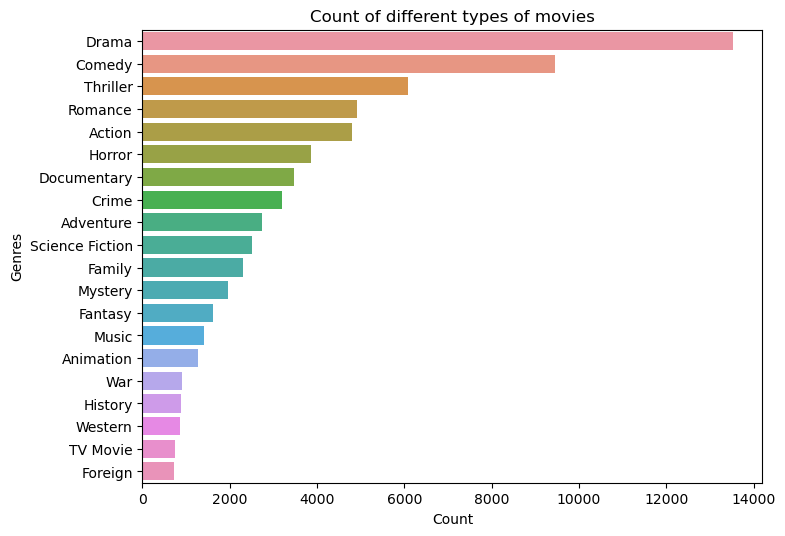

In [8]:
plt.figure(figsize = (8,6),dpi = 100)
sns.barplot(data = gen.reset_index().sort_values(by = 'id',ascending= False), x = "id", y = 'classfy',orient = 'h')
plt.title("Count of different types of movies")
plt.xlabel("Count")
plt.ylabel("Genres")
plt.show()

In [9]:
import plotly.express as px
# plot the overall trend of the movir quantities 
year.columns = ['release_year','Count of movies']

fig = px.line(year[year['release_year']<= 2015], x='release_year', y='Count of movies', title='The trend of movie quantities by year')

fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [10]:
title = 'Different top genres trend'
labels = ['Drama', 'Comedy','Thriller','Romance','Action']
colors = ['rgb(67,67,67)', 'rgb(115,115,115)', 'rgb(49,130,189)', 'rgb(189,189,189)','rgb(115,115,115)']
mode_size = [8, 8, 12, 8]
line_size = [2, 2, 4, 2]
x_data = np.vstack((np.arange(2005, 2017),)*4)
y_data = np.array([
    combine.loc['Drama'].iloc[-15:-3].values.flatten(),
    combine.loc['Comedy'].iloc[-15:-3].values.flatten(),
    combine.loc['Thriller'].iloc[-15:-3].values.flatten(),
    combine.loc['Romance'].iloc[-15:-3].values.flatten()])
fig = go.Figure()
for i in range(0, 4):
    fig.add_trace(go.Scatter(x=x_data[i], y=y_data[i], mode='lines',
        name=labels[i],line=dict(color=colors[i], width=line_size[i]),connectgaps=True,))
    fig.add_trace(go.Scatter(
        x=[x_data[i][0], x_data[i][-1]],y=[y_data[i][0], y_data[i][-1]],
        mode='markers',marker=dict(color=colors[i], size=mode_size[i])))
fig.update_layout(
    xaxis=dict(showline=True,showgrid=False,showticklabels=True,linecolor='rgb(204, 204, 204)',linewidth=2,
        ticks='outside',tickfont=dict(family='Arial',size=12,color='rgb(82, 82, 82)',),),
    yaxis=dict(showgrid=False,zeroline=False,showline=False,showticklabels=False,),
    autosize=False,margin=dict(autoexpand=False,l=100,r=20,t=110,),showlegend=False,plot_bgcolor='white')
annotations = []
for y_trace, label, color in zip(y_data, labels, colors):
    # labeling the left_side of the plot
    annotations.append(dict(xref='paper', x=0.05, y=y_trace[0],
                                  xanchor='right', yanchor='middle',
                                  text=label + ' {}'.format(y_trace[0]),
                                  font=dict(family='Arial',size=16),showarrow=False))
    # labeling the right_side of the plot
    annotations.append(dict(xref='paper', x=0.95, y=y_trace[11],
                                  xanchor='left', yanchor='middle',
                                  text='{}'.format(y_trace[11]),
                                  font=dict(family='Arial',size=16),showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Different types of movies\' trend',
                              font=dict(family='Arial',size=30,color='rgb(37,37,37)'),showarrow=False))
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.1,
                              xanchor='center', yanchor='top',
                              text='Source: Moives DataSet from CC0: Public Domain',
                              font=dict(family='Arial',size=12,color='rgb(150,150,150)'),showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

Build Movie rating model 
Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$  
* *v* is the number of votes for the movie
* *m* is the minimum votes required to be listed in the chart
* *R* is the average rating of the movie
* *C* is the mean vote across the whole report

In [52]:
# explore the top movies according to the weighted rating
vote_counts = data[data['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = data[data['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
m = vote_counts.quantile(0.95)

def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)
data['weighted'] = data.apply(weighted_rating,axis = 1)

# print the top 10 movies 
data.sort_values('weighted',ascending= False).loc[:,['title','weighted']].head(10)

,title,weighted
280,The Shawshank Redemption,8.262609
734,The Godfather,8.179341
10314,The Dark Knight,8.144355
2566,Fight Club,8.105232
265,Pulp Fiction,8.084122
315,Forrest Gump,7.978436
12503,Inception,7.972039
17744,Interstellar,7.940766
1023,The Empire Strikes Back,7.906598
482,Schindler's List,7.903698


## User-Rating based collaberative filtering part   
**Note:**  *In this part, we will utilize the surprise package to compare the performance of different user-rating based algorithms.*

In [11]:
from surprise import SVD
data2 = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], Reader())
svd = SVD()
svdmodel = surprise.model_selection.cross_validate(svd, data2, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9012  0.9041  0.9043  0.9032  0.0014  
MAE (testset)     0.6965  0.6960  0.6963  0.6963  0.0002  
Fit time          2.58    2.31    2.32    2.41    0.13    
Test time         0.14    0.14    0.15    0.15    0.00    


In [12]:
from surprise import BaselineOnly
algo = BaselineOnly()
basemodel = surprise.model_selection.cross_validate(algo, data2, measures=['RMSE', 'MAE'], cv=3,verbose=True)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8977  0.8977  0.8953  0.8969  0.0011  
MAE (testset)     0.6933  0.6957  0.6918  0.6936  0.0016  
Fit time          0.11    0.09    0.10    0.10    0.01    
Test time         0.11    0.22    0.10    0.14    0.05    


In [13]:
from surprise import KNNWithMeans
algo = KNNWithMeans()
meanmodel = surprise.model_selection.cross_validate(algo, data2, measures=['RMSE', 'MAE'], cv=3,verbose = True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9276  0.9298  0.9282  0.9285  0.0009  
MAE (testset)     0.7099  0.7111  0.7119  0.7110  0.0008  
Fit time          0.10    0.12    0.13    0.12    0.01    
Test time         1.53    1.47    1.56    1.52    0.04    


In [14]:
import plotly.graph_objects as go
import plotly.figure_factory as ff
table_data = [['Models','RMSE', 'MAE', 'Fit Time','Test Time'],
              ['svd',svdmodel['test_rmse'].mean().round(3),svdmodel['test_mae'].mean().round(3),round(svdmodel['fit_time'][1],3),round(svdmodel['test_time'][1],3)],
              ['base',basemodel['test_rmse'].mean().round(3),basemodel['test_mae'].mean().round(3),round(basemodel['fit_time'][1],3),round(basemodel['test_time'][1],3)],
              ['mean',meanmodel['test_rmse'].mean().round(3),meanmodel['test_mae'].mean().round(3),round(meanmodel['fit_time'][1],3),round(meanmodel['test_time'][1],3)]]
fig = ff.create_table(table_data, height_constant=20)
teams = ['SVD','Base','Mean']

# create four different bars 
nm = [svdmodel['test_rmse'].mean(),svdmodel['test_rmse'].mean(),svdmodel['test_rmse'].mean()]
fm = [svdmodel['test_mae'].mean(),svdmodel['test_mae'].mean(),svdmodel['test_mae'].mean()]
ns = [svdmodel['fit_time'][1],svdmodel['fit_time'][1],svdmodel['fit_time'][1]]
fs = [svdmodel['test_time'][1],svdmodel['test_time'][1],svdmodel['test_time'][1]]

# Make traces for graph
trace1 = go.Bar(x=teams, y=nm, xaxis='x2', yaxis='y2',
                marker=dict(color='#0099ff'),
                name='RMSE')
trace2 = go.Bar(x=teams, y=fm, xaxis='x2', yaxis='y2',
                marker=dict(color='#404040'),
                name='MAE')
trace3 = go.Bar(x=teams, y=ns, xaxis='x2', yaxis='y2',
                marker=dict(color='red'),
                name='Fit Time')
trace4 = go.Bar(x=teams, y=fs, xaxis='x2', yaxis='y2',
                marker=dict(color='green'),
                name='Test Time')
# Add trace data to figure
fig.add_traces([trace1, trace2,trace3,trace4])
# initialize xaxis2 and yaxis2
fig['layout']['xaxis2'] = {}
fig['layout']['yaxis2'] = {}

# Edit layout for subplots
fig.layout.yaxis.update({'domain': [0, .55]})
fig.layout.yaxis2.update({'domain': [.6, 1]})

# The graph's yaxis2 MUST BE anchored to the graph's xaxis2 and vice versa
fig.layout.yaxis2.update({'anchor': 'x2'})
fig.layout.xaxis2.update({'anchor': 'y2'})
fig.layout.yaxis2.update({'title': 'Comparisons'})

# Update the margins to add a title and see graph x-labels.
fig.layout.margin.update({'t':50, 'l':50})
fig.layout.update({'title': 'The Comparison of different models'})

# Update the height because adding a graph vertically will interact with the plot height calculated for the table
fig.layout.update({'height':400})
fig.show()

**Note:** *To our surprise, the baseline method has both the best RMSE performance and shortest training time.*

###  User-rating based CF Recommender  
**Note:** *In this part, we will implement the recommender algorithms to help us recommend movies according to the specified user and movie.*

In [16]:
from surprise import KNNWithMeans
rating_data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], Reader())
def user_based_CF_recommender(uid,k=15,recom_num=10,return_list=False):
    if not return_list:
        print('Recommendation Engine: User-based CF',)
        print('Recommendation for user',uid)
    user_id = uid
    algo = KNNWithMeans(verbose=False)
    trainset = rating_data.build_full_trainset()
    algo.fit(trainset)
    sim_matrix = algo.compute_similarities()
    neighbor_list = algo.get_neighbors(uid-1,15)

    count_dict = {}
    for uid in neighbor_list:
        sim = sim_matrix[user_id-1][uid-1]
        ratings_movies = set(ratings[ratings['userId'] == uid].movieId.tolist())
        for m in ratings_movies:
            if m not in count_dict:
                count_dict[m] = sim
            else:
                count_dict[m] += sim
    sorted_dict = {k: v for k, v in sorted(count_dict.items(), key=lambda item: item[1],reverse=True)}
    recommend_movie = list(sorted_dict.keys())[:31]
    final_recom = []
    count = 0
    for id in recommend_movie:
        t1 = data[data['id'] == id].title.tolist()
        if t1 != []:
            if count < recom_num:
                final_recom.append(id)
                count += 1
                if not return_list:
                    print('{}. {}'.format(count,t1[0]))
    if not return_list:
        return (final_recom, sorted_dict)
    else:
        return final_recom

In [17]:
recom,countdict = user_based_CF_recommender(1,k=15,recom_num=15)

Recommendation Engine: User-based CF
Recommendation for user 1
1. Terminator 3: Rise of the Machines
2. Young and Innocent
3. The Great Outdoors
4. My Tutor
5. Married to the Mob
6. One Night at McCool's
7. The Goddess
8. Night on Earth
9. Titanic
10. Cars
11. Ask the Dust
12. Batman Returns


In [18]:
mids = []
scores = []
for k in countdict:
    mids.append(k)
    scores.append(countdict[k])
pd.DataFrame({'Movie ID':mids, 'Recommendation score': scores})

,Movie ID,Recommendation score
0,296,1.791393
1,2762,1.621632
2,1198,1.483701
3,2617,1.483701
4,2193,1.483701
...,...,...
1286,1517,0.000000
1287,1007,0.000000
1288,1175,0.000000
1289,1348,0.000000


###  Description-based recommender  
**Note:** *In this part, we will make use the tf-idf matrix to recommend movies basing on the cosine similarity measurement.*

In [19]:
data['text'] = data['tagline'].fillna('') + data['overview'].fillna('')
data['text'].head()

0    Led by Woody, Andy's toys live happily in his ...
1    Roll the dice and unleash the excitement!When ...
2    Still Yelling. Still Fighting. Still Ready for...
3    Friends are the people who let you be yourself...
4    Just When His World Is Back To Normal... He's ...
Name: text, dtype: object

In [20]:
# Stemming algorithm
stemmer = SnowballStemmer('english')
data['text'] = data['text'].apply(lambda x: stemmer.stem(x))

In [21]:
# Find the cosine similarity score between the descriptions of each movie
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english',use_idf=True)
tfidf_matrix = tf.fit_transform(data['text'])

from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
indice = pd.Series(data.index,index = data['title'])

In [22]:
def description_recommender(name,recom_num=10):
    print('Recommendation Engine: description-based',)
    print('Recommendation from',name)
    idx = indice[name]
    similarity = list(enumerate(cosine_sim[idx]))
    similarity = sorted(similarity,key = lambda x:x[1], reverse = True)
    idxlist = [i[0] for i in similarity[1:recom_num+1]]
    recommend_list = data['title'].iloc[idxlist]
    for i in range(len(recommend_list)):
        print(str(i+1)+'.',recommend_list.iloc[i])

In [23]:
movie_name = 'Toy Story'
description_recommender(movie_name,recom_num=10)

Recommendation Engine: description-based
Recommendation from Toy Story
1. Toy Story 2
2. Toy Story 3
3. Small Fry
4. Andy Hardy's Blonde Trouble
5. The Champ
6. The 40 Year Old Virgin
7. Andy Kaufman Plays Carnegie Hall
8. Man on the Moon
9. Superstar: The Life and Times of Andy Warhol
10. Andy Peters: Exclamation Mark Question Point


In [24]:
idxlist = [2697, 12403, 18994, 18475, 7263, 8645, 31769, 2754, 28525, 31286]
sim_score = []
for id in idxlist:
    sim_score.append(cosine_sim[0][id])
names = ['Toy Story 2','Toy Story 3','Small Fry',"Andy Hardy's Blonde Trouble",'The Champ','The 40 Year Old Virgin','Andy Kaufman Plays Carnegie Hall','Man on the Moon','Superstar: The Life and Times of Andy Warhol','Andy Peters: Exclamation Mark Question Point']
pd.DataFrame({'Movie names':names,'Description similarity':sim_score})

,Movie names,Description similarity
0,Toy Story 2,0.239584
1,Toy Story 3,0.212397
2,Small Fry,0.113012
3,Andy Hardy's Blonde Trouble,0.099923
4,The Champ,0.099666
5,The 40 Year Old Virgin,0.089242
6,Andy Kaufman Plays Carnegie Hall,0.089238
7,Man on the Moon,0.088255
8,Superstar: The Life and Times of Andy Warhol,0.086806
9,Andy Peters: Exclamation Mark Question Point,0.081660


### Keywords-based recommender  
**Note:** *The improvement of the content-based method, this keywords-based recommender only consider the common keywords.*

In [26]:
num_movie = data.shape[0]
new_doc = []
self_voc = {}
count = 0
# Create new_doc, which is a list of keywords
for i in range(num_movie):
    key_lists = data.loc[(i,'keylist')]
    actors = data.loc[(i,'actors')]
    director = data.loc[(i,'director')]
    genres = data.loc[(i,'genres')]
    company = data.loc[(i,'production_companies')]
    str1 = ""
    str2 = ""
    str3 = ""
    if key_lists != []:
        for key in key_lists:
            key = key.replace(" ","")
            if key not in self_voc:
                self_voc[key] = count
                count += 1
            str1  = str1 + key + " "
    if actors != []:
        for actor in actors:
            if actor not in self_voc:
                self_voc[actor] = count
                count += 1
        str2 = " ".join(actors)
    if genres != []:
        for genre in genres:
            genre = genre.replace(" ","")
            if genre not in self_voc:
                self_voc[genre] = count
                count += 1
            str3  = str3 + genre + " "
        str1 = str1 + " "+ str2 + " " + str3 + " "
    if type(director) != float:
        if director not in self_voc:
            self_voc[director] = count
            count += 1
        str1 = str1 + director + " "
    if type(company) != float:
        if company not in self_voc:
            self_voc[company] = count
            count += 1
        str1 = str1 +company
    new_doc.append(str1)
data['new_doc'] = new_doc

In [27]:
ct = CountVectorizer(analyzer='word',lowercase=False,ngram_range=(1,9),vocabulary=self_voc)
count_matrix = ct.fit_transform(data['new_doc'])

from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(count_matrix, count_matrix)
indice = pd.Series(data.index,index = data['title'])

In [28]:
# Recommendation engine
def keywords_recommender(name,recom_num=10,return_list=False):
    idx = indice[name]
    similarity = list(enumerate(cosine_sim[idx]))
    similarity = sorted(similarity,key = lambda x:x[1], reverse = True)
    idxlist = [i[0] for i in similarity[1:recom_num+1]]
    title_list = data['title'].iloc[idxlist].tolist()[:recom_num]
    if not return_list:
        print('Recommendation Engine: keywords-based',)
        print('Recommendation from',movie_name)
        for i in range(len(title_list)):
            print('{}. {}'.format(i+1,title_list[i]))
    else:
        return idxlist

In [29]:
movie_name = 'The Shawshank Redemption'
keywords_recommender(movie_name,recom_num=15)

Recommendation Engine: keywords-based
Recommendation from The Shawshank Redemption
1. The Green Mile
2. Malcolm X
3. Dead Man Walking
4. Strange Days
5. Dolores Claiborne
6. Murder in the First
7. The Hudsucker Proxy
8. In the Line of Fire
9. The Spitfire Grill
10. Hurricane Streets
11. Witness
12. Palmetto
13. The Limey
14. Papillon
15. Antitrust


In [30]:
idxlist = [2697, 19921, 12403, 3637, 11259, 14991, 17732, 18992, 18994, 2393, 5522]
sim_score = []
for id in idxlist:
    sim_score.append(cosine_sim[0][id])
names = ['Toy Story 2', 'Toy Story That Time Forgot', 'Toy Story 3', "Recess: School's Out", 'Up', 'One Man Band', "Dug's Special Mission", 'Hawaiian Vacation', 'Small Fry', 'The Iron Giant', 'Finding Nemo']
pd.DataFrame({'Movie names':names,'Count similarity':sim_score})

,Movie names,Count similarity
0,Toy Story 2,12.0
1,Toy Story That Time Forgot,9.0
2,Toy Story 3,8.0
3,Recess: School's Out,7.0
4,Up,7.0
5,One Man Band,7.0
6,Dug's Special Mission,7.0
7,Hawaiian Vacation,7.0
8,Small Fry,7.0
9,The Iron Giant,6.0


### Hybrid recommender  
**Note:** *The hypbrid method combining both baseline method and keyword-based method.*

In [31]:
from surprise import BaselineOnly
def Hybrid_recommender(uid,mn,recom_num=10):
    print('Recommendation engine: Hybrid')
    print('Recommendation for user {}'.format(uid))
    print('After watching {}, you may like:'.format(mn))
    algo = BaselineOnly(verbose=False)
    trainset = rating_data.build_full_trainset()
    algo.fit(trainset)
    mb_list = keywords_recommender(mn,return_list=True,recom_num=15)
    mb_list = data['id'].iloc[mb_list].tolist()
    ub_list = user_based_CF_recommender(uid,return_list=True,recom_num=15)
    cand = mb_list + ub_list
    cand_pred = []
    for c in cand:
        prediction = algo.predict(uid, c)
        cand_pred.append(prediction.est)
    df = pd.DataFrame({'id':cand, 'pred_rating':cand_pred})
    df.sort_values(by='pred_rating',ascending=False,inplace=True)
    recom_order = df.id.tolist()
    recom_count = 0
    for cid in recom_order:
        t = data[data['id']==cid].title.tolist()
        if t != []:
            recom_count += 1
            print('{}. {}'.format(recom_count,t[0]))
        if recom_count >= recom_num:
            break

In [32]:
Hybrid_recommender(1,'The Shawshank Redemption',recom_num=10)

Recommendation engine: Hybrid
Recommendation for user 1
After watching The Shawshank Redemption, you may like:
1. Terminator 3: Rise of the Machines
2. Cars
3. Young and Innocent
4. The Green Mile
5. One Night at McCool's
6. Strange Days
7. Batman Returns
8. Married to the Mob
9. The Goddess
10. Ask the Dust


### Deep Learning method  
**Note:** *In this part, we will try to utilize the deep learning method to implement the GMF and MLP method.*

In [44]:
X = ratings.iloc[:,:2]
Y = ratings.iloc[:,2]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 66)
# The number of latent factors for the embedding
n_latent_factors = 50
# no of users and movies
n_users, n_movies = len(ratings['userId'].unique()), len(ratings['movieId'].unique()) 

#### GMF- model 

In [45]:
# User Embeddings
user_input = Input(shape=(1,), name='User_Input')
user_embeddings = Embedding(input_dim = n_users, output_dim=n_latent_factors, input_length=1, 
                              name='User_Embedding') (user_input)
user_vector = Flatten(name='User_Vector') (user_embeddings)
# Movie Embeddings
movie_input = Input(shape=(1,), name='Movie_Input')
movie_embeddings = Embedding(input_dim = n_movies, output_dim=n_latent_factors, input_length=1, 
                               name='Movie_Embedding') (movie_input)
movie_vector = Flatten(name='Movie_Vector') (movie_embeddings)
# Dot Product
merged_vectors = dot([user_vector, movie_vector], name='Dot_Product', axes=1)
model = Model([user_input, movie_input], merged_vectors)

In [46]:
optimizer = Adam(lr = 0.0005)

model.compile(loss='mean_squared_error', optimizer = optimizer)

In [47]:
batch_size = 128
epochs = 20
history = model.fit(x=[x_train['userId'], x_train['movieId']], y=y_train, batch_size= batch_size, epochs=epochs, \
                    verbose= 2, validation_data=([x_test['userId'], x_test['movieId']], y_test))

Epoch 1/20
626/626 - 4s - loss: 13.6413 - val_loss: 13.4453 - 4s/epoch - 6ms/step
Epoch 2/20
626/626 - 2s - loss: 11.3218 - val_loss: 8.1918 - 2s/epoch - 3ms/step
Epoch 3/20
626/626 - 2s - loss: 5.8834 - val_loss: 4.7229 - 2s/epoch - 3ms/step
Epoch 4/20
626/626 - 2s - loss: 4.0090 - val_loss: 3.8260 - 2s/epoch - 3ms/step
Epoch 5/20
626/626 - 2s - loss: 3.3891 - val_loss: 3.4302 - 2s/epoch - 3ms/step
Epoch 6/20
626/626 - 2s - loss: 3.0890 - val_loss: 3.2231 - 2s/epoch - 3ms/step
Epoch 7/20
626/626 - 2s - loss: 2.9207 - val_loss: 3.1030 - 2s/epoch - 3ms/step
Epoch 8/20
626/626 - 2s - loss: 2.8175 - val_loss: 3.0296 - 2s/epoch - 3ms/step
Epoch 9/20
626/626 - 2s - loss: 2.7490 - val_loss: 2.9834 - 2s/epoch - 3ms/step
Epoch 10/20
626/626 - 2s - loss: 2.7011 - val_loss: 2.9528 - 2s/epoch - 3ms/step
Epoch 11/20
626/626 - 2s - loss: 2.6653 - val_loss: 2.9317 - 2s/epoch - 3ms/step
Epoch 12/20
626/626 - 2s - loss: 2.6368 - val_loss: 2.9186 - 2s/epoch - 3ms/step
Epoch 13/20
626/626 - 2s - loss: 2

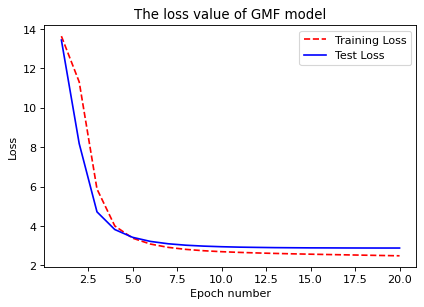

In [48]:
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

plt.figure(figsize = (6,4),dpi = 80)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.title("The loss value of GMF model")
plt.show()

#### MLP-model 

In [49]:
# User Embeddings
user_input = Input(shape=(1,), name='User_Input')
user_embeddings = Embedding(input_dim = n_users, output_dim=n_latent_factors, input_length=1, 
                              name='User_Embedding') (user_input)
user_vector = Flatten(name='User_Vector') (user_embeddings)

# Movie Embeddings
movie_input = Input(shape=(1,), name='Movie_Input')
movie_embeddings = Embedding(input_dim = n_movies, output_dim=n_latent_factors, input_length=1, 
                               name='Movie_Embedding') (movie_input)
movie_vector = Flatten(name='Movie_Vector') (movie_embeddings)

# Concatenate Product
merged_vectors = concatenate([user_vector, movie_vector], name='Concantenate')
dense_layer_1 = Dense(100, activation='relu')(merged_vectors) 
result = Dense(1)(dense_layer_1)
model = Model([user_input, movie_input], result)

optimizer = Adam(lr=0.0002)
model.compile(loss='mean_squared_error', optimizer=optimizer)

batch_size = 128
epochs = 20
history = model.fit(x=[x_train['userId'], x_train['movieId']], y=y_train, batch_size= batch_size, epochs=epochs, 
                    verbose= 2, validation_data=([x_test['userId'], x_test['movieId']], y_test))

Epoch 1/20
626/626 - 3s - loss: 4.9405 - val_loss: 1.0057 - 3s/epoch - 4ms/step
Epoch 2/20
626/626 - 2s - loss: 0.8881 - val_loss: 0.8551 - 2s/epoch - 3ms/step
Epoch 3/20
626/626 - 2s - loss: 0.8076 - val_loss: 0.8302 - 2s/epoch - 3ms/step
Epoch 4/20
626/626 - 2s - loss: 0.7828 - val_loss: 0.8223 - 2s/epoch - 4ms/step
Epoch 5/20
626/626 - 2s - loss: 0.7687 - val_loss: 0.8199 - 2s/epoch - 4ms/step
Epoch 6/20
626/626 - 2s - loss: 0.7588 - val_loss: 0.8140 - 2s/epoch - 3ms/step
Epoch 7/20
626/626 - 2s - loss: 0.7522 - val_loss: 0.8127 - 2s/epoch - 3ms/step
Epoch 8/20
626/626 - 2s - loss: 0.7460 - val_loss: 0.8116 - 2s/epoch - 3ms/step
Epoch 9/20
626/626 - 2s - loss: 0.7412 - val_loss: 0.8105 - 2s/epoch - 3ms/step
Epoch 10/20
626/626 - 2s - loss: 0.7354 - val_loss: 0.8105 - 2s/epoch - 3ms/step
Epoch 11/20
626/626 - 2s - loss: 0.7302 - val_loss: 0.8078 - 2s/epoch - 3ms/step
Epoch 12/20
626/626 - 2s - loss: 0.7244 - val_loss: 0.8028 - 2s/epoch - 3ms/step
Epoch 13/20
626/626 - 2s - loss: 0.71

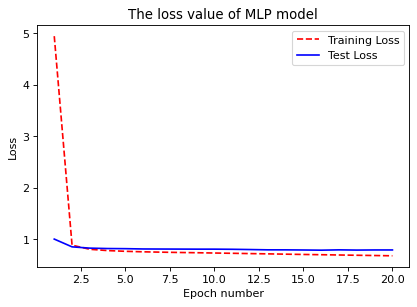

In [50]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (6,4),dpi = 80)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.title("The loss value of MLP model")
plt.show()

In [51]:
score = model.evaluate([x_test['userId'], x_test['movieId']], y_test)

print()
print('RMSE: {:.4f}'.format(np.sqrt(score)))

626/626 [==============================] - 1s 1ms/step - loss: 0.7949

RMSE: 0.8916


*That's all for the project code, thanks for the referential documents and articles.*
****